#### Parâmetros Iniciais
##### Leitura de bibliotecas, definição de variáveis e leitura da base de dados.

In [1]:
# bibliotecas
import pandas as pd
import numpy as np
import random
import nltk
from nltk.stem import RSLPStemmer
nltk.download('rslp')
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn import metrics
from pydiffmap import diffusion_map as dm
import seaborn as sns
import matplotlib.pyplot as plt

# variaveis
my_colors = {'84313900': '#88138e',
             '84833090': '#25e118',
             '73259910': '#e02c1a',
             '84379000': '#21cae1',
             '40082100': '#1b228f',
             '73089090': '#000000',
             '73089010': '#773525',
             '69091290': '#ffcf1a',
             '72085100': '#d00a9b',
             '73181500': '#389400',
             '85371090': '#FF7F00'}

[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\franc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# importar base de dados
dados_p1 = pd.read_excel("agrupado_p1.xlsx", dtype={'Número do item': str, 'Código de classificação fiscal': str})
dados_p2 = pd.read_excel("agrupado_p2.xlsx", dtype={'Número do item': str, 'Código de classificação fiscal': str})
dados = pd.concat([dados_p1, dados_p2], ignore_index=True)
dados.head()

,Data e hora de criação,Categoria,Número do item,Nome do produto,Descrição,Nome da pesquisa,Tipo de produto,Subtipo de produto,Tecnologia de configuração,Parado (Compra),...,Grupo de impostos do item,Peso líquido,Peso bruto,Unidade de estoque,Categoria de projeto,Centro de custos,Departamento,Código de classificação fiscal,Tipo de produto2,Ano
0,2015-03-23 14:58:11,PEDIDOS DE VENDA,7519505,VALE - SERRA DOS CARAJAS PV-06320P PARAUAPEBAS,VALE - SERRA DOS CARAJAS PV-06320P PARAUAPEBAS,VALE - SERRA DOS CARAJAS PV-06320P PARAUAPEBAS,Item,Produto,NaN,Não,...,NaN,0.0,0.0,UN,FAT_PROJ_VENDA_MI,NaN,NaN,NaN,4,2015
1,2015-01-02 07:05:36,03-PRODUTO EM PROCESSO OU MANUFATURADO,T0002551,ESTRUTURA TRELICADA,ESTRUTURA TRELICADA,ESTRUTURA TRELICADA,Item,Produto,NaN,Não,...,INIPI 51,0.0,0.0,UN,CUSTO_PROJETO,NaN,NaN,84314910,3,2015
2,2015-01-02 07:11:21,03-PRODUTO EM PROCESSO OU MANUFATURADO,T0002552,PILAR P-1 2025X6478,PILAR P-1 2025X6478,PILAR P-1 2025X6478,Item,Produto,NaN,Não,...,INIPI 51,0.0,0.0,UN,CUSTO_PROJETO,NaN,NaN,84314910,3,2015
3,2015-01-02 07:31:19,03-PRODUTO EM PROCESSO OU MANUFATURADO,T0002553,ITEM A - BASE DA ROTULA,ITEM A - BASE DA ROTULA,ITEM A - BASE DA ROTULA,Item,Produto,NaN,Não,...,INIPI 51,0.0,0.0,UN,CUSTO_PROJETO,NaN,NaN,84314910,3,2015
4,2015-01-02 07:40:20,03-PRODUTO EM PROCESSO OU MANUFATURADO,T0002554,CHAPA,CHAPA,CHAPA,Item,Produto,NaN,Não,...,INIPI 51,0.0,0.0,UN,CUSTO_PROJETO,NaN,NaN,72085200,3,2015


#### Ajuste do Banco de Dados

##### Remoção de observações com registros errados da base, colunas não utilizadas para nossa análise e alteração dos nomes da colunas remanescentes para melhor manuseio durante o programa.

##### Colunas mantidas e renomeadas:
- "Número do item" &rarr; "ID";
- "Descrição" &rarr; "DESC";
- "Código de classificação fiscal" &rarr; "NCM".

##### Dados removidos:

- "ID" repetidos (mantido a primeira ocorrência);
- Observações com dados faltantes;
- "NCM" registrados errado ("00000000", "99999999" ou com número de dígitos diferente de oito);
- Observações duplicadas com 'DESC' e 'NCM' repetidos.

In [3]:
# dimensao dos dados
dados.shape

(267600, 26)

In [4]:
# manter colunas necessarias para analise
dados = dados.loc[:, ['Número do item', 'Descrição', 'Código de classificação fiscal']]

# renomear colunas
dados = dados.rename(columns={'Número do item': 'ID', 'Descrição': 'DESC', 'Código de classificação fiscal': 'NCM'})

# remover ID's repetidas
dados = dados.drop_duplicates(subset='ID', keep="first")

# remover observacoes com dados faltantes
dados = dados.dropna()

# dropar NCM registrados de forma errada
dados = dados[(dados['NCM'] != "00000000")
               & (dados['NCM'] != "99999999")
               & (dados['NCM'].str.len() == 8)]

# dropar colunas repetidas em DESC e NCM
dados = dados.drop_duplicates(subset=['DESC', 'NCM'])

# visualizar dados
dados.head()

,ID,DESC,NCM
1,T0002551,ESTRUTURA TRELICADA,84314910
2,T0002552,PILAR P-1 2025X6478,84314910
3,T0002553,ITEM A - BASE DA ROTULA,84314910
4,T0002554,CHAPA,72085200
6,T0002556,ITEM B - BASE ROTULA,84314910


In [5]:
# dimensao dos dados
dados.shape

(97267, 3)

#### Análise Descritiva, Amostragem e Stemização
##### Análise da distribuição dos dados, amostragem aleatória sem reposição de tamanho 500 para todas as categorias com 500 ou mais observações de tamanho de amostra por categoria e ajuste dos textos de "DESC" usando stemmer.

In [6]:
# salvar dados em uma outra variavel
df = dados

In [7]:
# agrupar dados pela coluna NCM e contar as quantidades
agrupado = dados.groupby('NCM').size()
quantidades = agrupado.tolist()

# analise descritiva dos dados
print("-- Análise Descritiva NCMs --")
total_ncms = len(quantidades)
print("Total:", total_ncms)
media = np.mean(quantidades)
print("Média:", media)
moda = np.argmax(np.bincount(quantidades))
print("Moda:", moda)
mediana = np.median(quantidades)
print("Mediana:", mediana)
primeiro_quartil = np.percentile(quantidades, 25)
print("Primeiro Quartil:", primeiro_quartil)
terceiro_quartil = np.percentile(quantidades, 75)
print("Terceiro Quartil:", terceiro_quartil)
valor_minimo = np.min(quantidades)
print("Valor Mínimo:", valor_minimo)
valor_maximo = np.max(quantidades)
print("Valor Máximo:", valor_maximo)

-- Análise Descritiva NCMs --
Total: 695
Média: 139.9525179856115
Moda: 1
Mediana: 4.0
Primeiro Quartil: 1.0
Terceiro Quartil: 17.0
Valor Mínimo: 1
Valor Máximo: 54939


In [8]:
# contar o numero de observações por NCM (categoria)
ncm_count = df['NCM'].value_counts()

# filtrar categorias com menos de 500 linhas
ncm_count = ncm_count[ncm_count >= 500]

# pegar uma categoria igual a 500 para cada categoria
samples = []
for ncm in ncm_count.index:
    ncm_sample = df[df['NCM'] == ncm].sample(n=500, random_state=28)
    samples.append(ncm_sample)

# concatenar amostras em um unico dataframe
df = pd.concat(samples)

# resetar index
df = df.reset_index(drop=True)

# visualizar dados
df.head()

,ID,DESC,NCM
0,T0016029,BARRA QUADRADO,73259910
1,T0015482,NERVURA 01,73259910
2,T0121769,CJS PLENUM TUBO INJETOR AR COMPRIMIDO,73259910
3,T0102294,ACESSORIOS RODA MOVIDA,73259910
4,T0128441,CABO RNC1244/2020,73259910


In [9]:
# dimensao dos dados
df.shape

(5500, 3)

In [10]:
# verificar total de termos - antes do RSLP
count_terms = CountVectorizer(binary=True)
count_terms.fit_transform(df['DESC'])
print(count_terms.get_feature_names_out())
print("Total de Termos antes do RSLP:",len(count_terms.get_feature_names_out()))

['00' '000' '0000' ... 'zona' 'zxhd' 'zxl']
Total de Termos antes do RSLP: 7052


In [11]:
# criar objeto stemmer em portugues
stemmer = RSLPStemmer()

# definir funcao para aplicar para cada palavra
def stem_text(text):
    return ' '.join([stemmer.stem(token) for token in text.split()])

# aplicar funcao
df['DESC'] = df['DESC'].apply(stem_text)

# visualizar dados
df.head()

,ID,DESC,NCM
0,T0016029,barr quadr,73259910
1,T0015482,nerv 01,73259910
2,T0121769,cj plenum tub inje ar comprim,73259910
3,T0102294,acessori rod mov,73259910
4,T0128441,cab rnc1244/2020,73259910


In [12]:
# verificar total de termos - depois do RSLP
count_terms = CountVectorizer(binary=True)
count_terms.fit_transform(df['DESC'])
print(count_terms.get_feature_names_out())
print("Total de Termos depois do RSLP:",len(count_terms.get_feature_names_out()))

['00' '000' '0000' ... 'zon' 'zxhd' 'zxl']
Total de Termos depois do RSLP: 6754


#### Bag-of-Words e t-SNE
##### Divisão dos dados em treino e teste.
##### Criação de BOWs diferentes para a base diferenciando entre:
- Definição de termos (palavra por palavra ou palavras por palavra mais palavras dois a dois);
- Tipo de métrica (Boolean, Frequency ou TF-IDF).

#### Total de seis modelos BOW.

##### Plots de gráficos através do método t-SNE.

In [13]:
# dividir dataframe em conjuntos de treino (70%) e teste (30%)
df_train, df_test = train_test_split(df, test_size=0.30, random_state=28)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [14]:
# verificar total de termos - base treino
count_terms = CountVectorizer(binary=True)
count_terms.fit_transform(df_train['DESC'])
print(count_terms.get_feature_names_out())
print("Total de Termos:",len(count_terms.get_feature_names_out()))

['00' '000' '0000' ... 'zincada' 'zon' 'zxl']
Total de Termos: 5374


In [15]:
# verificar total de termos - base teste
count_terms = CountVectorizer(binary=True)
count_terms.fit_transform(df_test['DESC'])
print(count_terms.get_feature_names_out())
print("Total de Termos:",len(count_terms.get_feature_names_out()))

['00' '000' '0000' ... 'zincada' 'zon' 'zxhd']
Total de Termos: 3090


#### Boolean
##### Termo = palavra por palavra

In [16]:
# criar um objeto countbectorizer com binary=True e ngram_range=(1, 1)
vectorizer_boolean_v1 = CountVectorizer(binary=True)

# criar matriz bag-of-words
bow_matrix = vectorizer_boolean_v1.fit_transform(df_train['DESC'])

# converter a matriz bag-of-words em dataframe
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer_boolean_v1.get_feature_names_out())

# combinar o dataframe original com o dataframe bag-of-words
df_bolean_v1 = pd.concat([df_train, bow_df], axis=1)

# visualizar dados
df_bolean_v1.head()

,ID,DESC,NCM,00,000,0000,00000,00001,00002,00003,...,xtb,xw,y11,yr,z7,zf4,zinc,zincada,zon,zxl
0,T0059023,transica superi el-06-07 conf de 70901564,84313900,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TP0019859,caix metal p/rol marc fcm ref sbma-22-bc-tfr 2...,84833090,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,T0030762,registr pneuma 550 x 550 - cilindr ext,73259910,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,T0040384,cj apoi 03 estrut,84379000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,T0101129,"lencol de borrach nbr 3/16plg - 4,8x51x1230mm ...",40082100,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


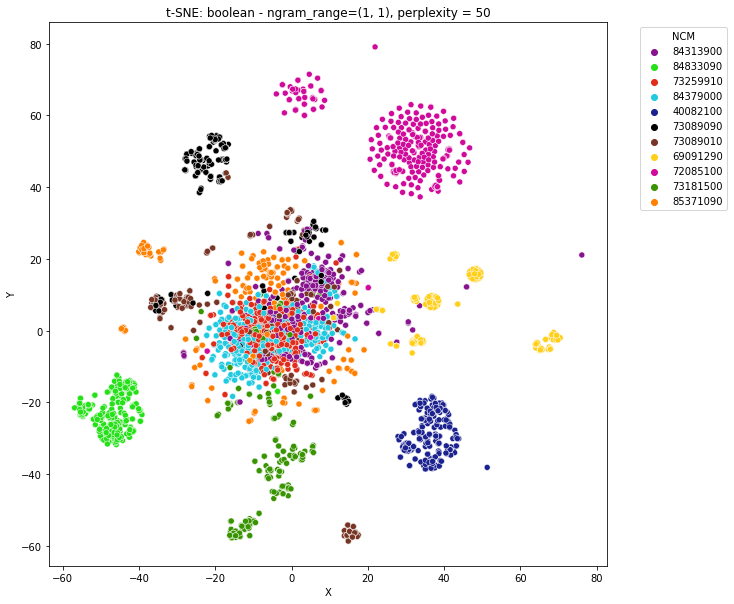

In [17]:
# calcular t-SNE para o dataframe boolean (ngram_range=(1, 1)), perplexity = 50
TSNE_bolean_v1 = TSNE(n_components=2,
                      random_state=28,
                      perplexity=50,
                      early_exaggeration=12,
                      learning_rate='auto',
                      n_iter=1000,
                      init='pca').fit_transform(df_bolean_v1.iloc[:, 3:])

df_TSNE = pd.DataFrame(TSNE_bolean_v1, columns=['X', 'Y'])
df_TSNE_bolean_v1 = pd.concat([df_bolean_v1.iloc[:, :3], df_TSNE], axis=1)

# plot t-SNE
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_TSNE_bolean_v1, x='X', y='Y', hue='NCM', palette=my_colors)
plt.title("t-SNE: boolean - ngram_range=(1, 1), perplexity = 50")
plt.legend(title='NCM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##### Termo = palavra por palavra mais palavras dois a dois

In [18]:
# criar um objeto CountVectorizer com binary=True e ngram_range=(1, 1)
vectorizer_boolean_v2 = CountVectorizer(binary=True, ngram_range=(1,2))

# criar matriz bag-of-words
bow_matrix = vectorizer_boolean_v2.fit_transform(df_train['DESC'])

# converter a matriz bag-of-words em dataframe
bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer_boolean_v2.get_feature_names_out())

# combinar o dataframe original com o dataframe bag-of-words
df_bolean_v2 = pd.concat([df_train, bow_df], axis=1)

# visualizar dados
df_bolean_v2.head()

,ID,DESC,NCM,00,00 00,00 cp,00 mb1,00 pe,00 sp1,000,...,zinc marc,zinc pacot,zinc pin,zincada,zincada fur,zincada plaquet,zon,zon 21,zxl,zxl laranj
0,T0059023,transica superi el-06-07 conf de 70901564,84313900,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TP0019859,caix metal p/rol marc fcm ref sbma-22-bc-tfr 2...,84833090,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,T0030762,registr pneuma 550 x 550 - cilindr ext,73259910,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,T0040384,cj apoi 03 estrut,84379000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,T0101129,"lencol de borrach nbr 3/16plg - 4,8x51x1230mm ...",40082100,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


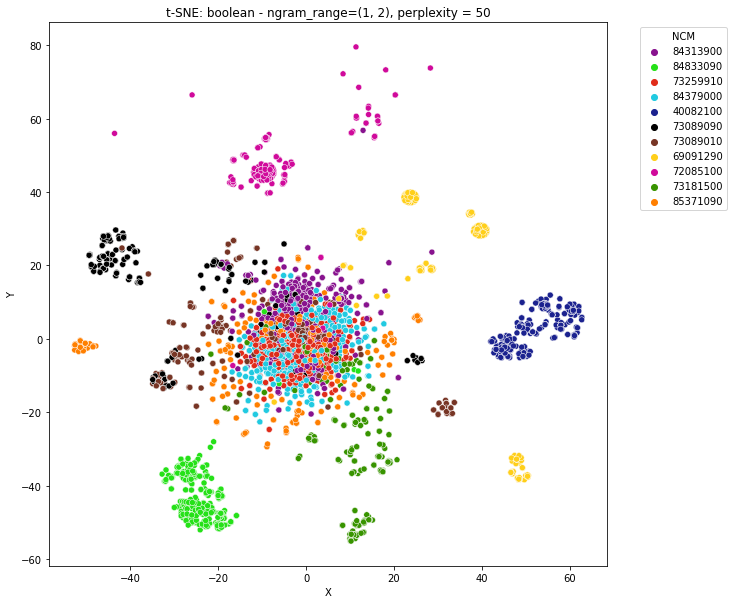

In [19]:
# calcular t-SNE para o dataframe boolean (ngram_range=(1, 2)), perplexity = 50
TSNE_bolean_v2 = TSNE(n_components=2,
                      random_state=28,
                      perplexity=50,
                      early_exaggeration=12,
                      learning_rate='auto',
                      n_iter=1000,
                      init='pca').fit_transform(df_bolean_v2.iloc[:, 3:])

df_TSNE = pd.DataFrame(TSNE_bolean_v2, columns=['X', 'Y'])
df_TSNE_bolean_v2 = pd.concat([df_bolean_v2.iloc[:, :3], df_TSNE], axis=1)

# plot t-SNE
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_TSNE_bolean_v2, x='X', y='Y', hue='NCM', palette=my_colors)
plt.title("t-SNE: boolean - ngram_range=(1, 2), perplexity = 50")
plt.legend(title='NCM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Frequency
##### Termo = palavra por palavra

In [20]:
# criar um objeto countvectorizer com termo = ngram_range=(1, 1)
vectorizer_frequency_v1 = CountVectorizer()

# criar matriz bag-of-words
bow_matrix = vectorizer_frequency_v1.fit_transform(df_train['DESC'])

# converter a matriz bag-of-words em dataframe
tf_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer_frequency_v1.get_feature_names_out())

# combinar o dataframe original com o dataframe bag-of-words
df_freq_v1 = pd.concat([df_train, tf_df], axis=1)

# visualizar dados
df_freq_v1.head()

,ID,DESC,NCM,00,000,0000,00000,00001,00002,00003,...,xtb,xw,y11,yr,z7,zf4,zinc,zincada,zon,zxl
0,T0059023,transica superi el-06-07 conf de 70901564,84313900,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TP0019859,caix metal p/rol marc fcm ref sbma-22-bc-tfr 2...,84833090,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,T0030762,registr pneuma 550 x 550 - cilindr ext,73259910,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,T0040384,cj apoi 03 estrut,84379000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,T0101129,"lencol de borrach nbr 3/16plg - 4,8x51x1230mm ...",40082100,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


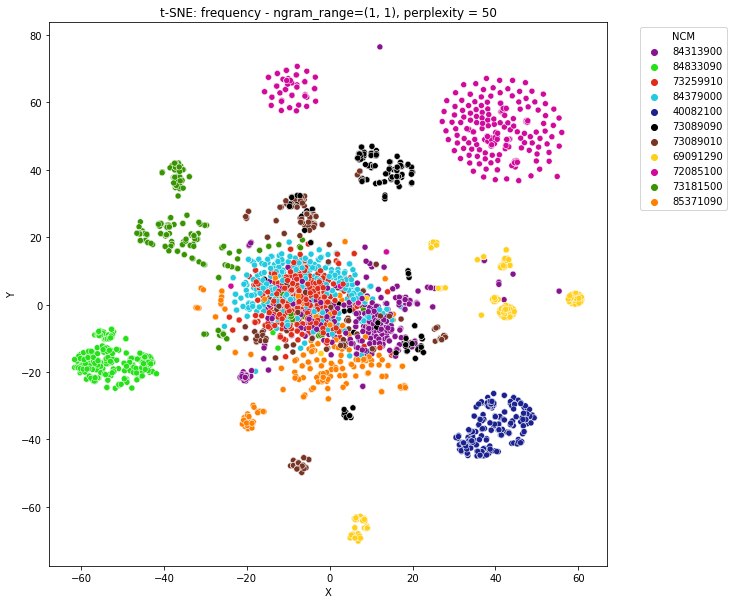

In [21]:
# calcular t-SNE para o dataframe frequency (ngram_range=(1, 1)), perplexity = 50
TSNE_freq_v1 = TSNE(n_components=2,
                      random_state=28,
                      perplexity=50,
                      early_exaggeration=12,
                      learning_rate='auto',
                      n_iter=1000,
                      init='pca').fit_transform(df_freq_v1.iloc[:, 3:])

df_TSNE = pd.DataFrame(TSNE_freq_v1, columns=['X', 'Y'])
df_TSNE_freq_v1 = pd.concat([df_freq_v1.iloc[:, :3], df_TSNE], axis=1)

# plot t-SNE
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_TSNE_freq_v1, x='X', y='Y', hue='NCM', palette=my_colors)
plt.title("t-SNE: frequency - ngram_range=(1, 1), perplexity = 50")
plt.legend(title='NCM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##### Termo = palavra por palavra mais palavras dois a dois

In [22]:
# criar um objeto countvectorizer objeto com ngram_range=(1,2)
vectorizer_frequency_v2 = CountVectorizer(ngram_range=(1,2))

# criar matriz bag-of-words
bow_matrix = vectorizer_frequency_v2.fit_transform(df_train['DESC'])

# converter a matriz bag-of-words em dataframe
tf_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer_frequency_v2.get_feature_names_out())

# combinar o dataframe original com o dataframe bag-of-words
df_freq_v2 = pd.concat([df_train, tf_df], axis=1)

# visualizar dados
df_freq_v2.head()

,ID,DESC,NCM,00,00 00,00 cp,00 mb1,00 pe,00 sp1,000,...,zinc marc,zinc pacot,zinc pin,zincada,zincada fur,zincada plaquet,zon,zon 21,zxl,zxl laranj
0,T0059023,transica superi el-06-07 conf de 70901564,84313900,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,TP0019859,caix metal p/rol marc fcm ref sbma-22-bc-tfr 2...,84833090,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,T0030762,registr pneuma 550 x 550 - cilindr ext,73259910,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,T0040384,cj apoi 03 estrut,84379000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,T0101129,"lencol de borrach nbr 3/16plg - 4,8x51x1230mm ...",40082100,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


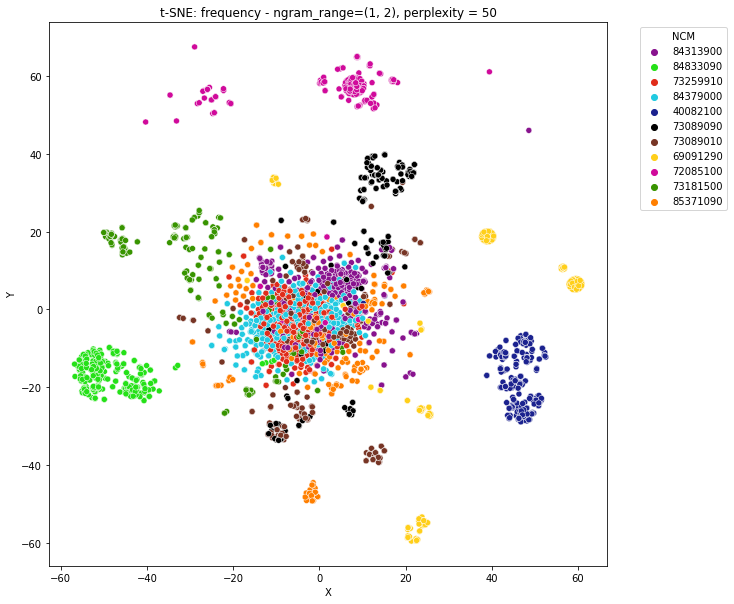

In [23]:
# calcular t-SNE para o dataframe frequency (ngram_range=(1, 2)), perplexity = 50
TSNE_freq_v2 = TSNE(n_components=2,
                      random_state=28,
                      perplexity=50,
                      early_exaggeration=12,
                      learning_rate='auto',
                      n_iter=1000,
                      init='pca').fit_transform(df_freq_v2.iloc[:, 3:])

df_TSNE = pd.DataFrame(TSNE_freq_v2, columns=['X', 'Y'])
df_TSNE_freq_v2 = pd.concat([df_freq_v2.iloc[:, :3], df_TSNE], axis=1)

# plot t-SNE
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_TSNE_freq_v2, x='X', y='Y', hue='NCM', palette=my_colors)
plt.title("t-SNE: frequency - ngram_range=(1, 2), perplexity = 50")
plt.legend(title='NCM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### TF-IDF
##### Termo = palavra por palavra

In [24]:
# criar um objeto tfidfvectorizer objeto com ngram_range=(1,1)
vectorizer_TFIDF_v1 = TfidfVectorizer()

# criar uma matriz TF-IDF
tfidf_matrix = vectorizer_TFIDF_v1.fit_transform(df_train['DESC'])

# converter a matriz TF-IDF em um dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer_TFIDF_v1.get_feature_names_out())

# combinar o dataframe original com o dataframe bag-of-words
df_tfidf_v1 = pd.concat([df_train, tfidf_df], axis=1)

# visualizar dados
df_tfidf_v1.head()

,ID,DESC,NCM,00,000,0000,00000,00001,00002,00003,...,xtb,xw,y11,yr,z7,zf4,zinc,zincada,zon,zxl
0,T0059023,transica superi el-06-07 conf de 70901564,84313900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TP0019859,caix metal p/rol marc fcm ref sbma-22-bc-tfr 2...,84833090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,T0030762,registr pneuma 550 x 550 - cilindr ext,73259910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,T0040384,cj apoi 03 estrut,84379000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,T0101129,"lencol de borrach nbr 3/16plg - 4,8x51x1230mm ...",40082100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


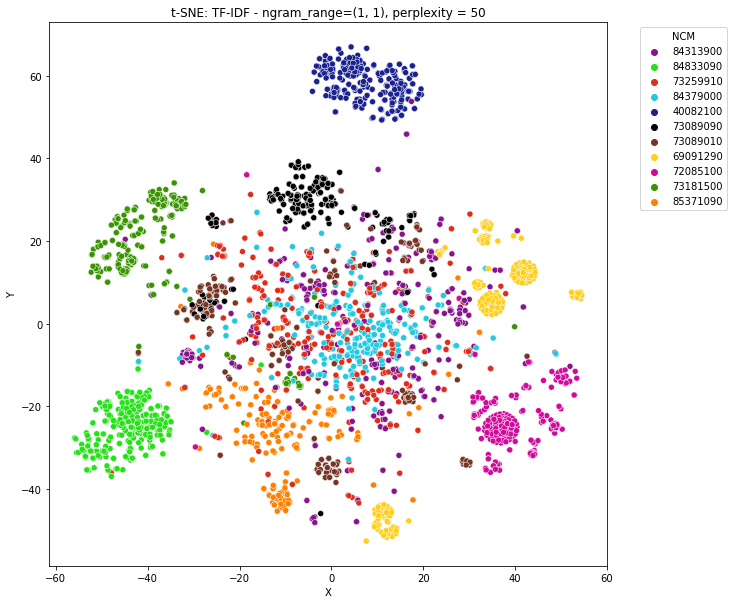

In [25]:
# calcular t-SNE para o dataframe TF-IDF (ngram_range=(1, 1)), perplexity = 50
TSNE_tfidf_v1 = TSNE(n_components=2,
                      random_state=28,
                      perplexity=50,
                      early_exaggeration=12,
                      learning_rate='auto',
                      n_iter=1000,
                      init='pca').fit_transform(df_tfidf_v1.iloc[:, 3:])

df_TSNE = pd.DataFrame(TSNE_tfidf_v1, columns=['X', 'Y'])
df_TSNE_tfidf_v1 = pd.concat([df_tfidf_v1.iloc[:, :3], df_TSNE], axis=1)

# plot t-SNE
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_TSNE_tfidf_v1, x='X', y='Y', hue='NCM', palette=my_colors)
plt.title("t-SNE: TF-IDF - ngram_range=(1, 1), perplexity = 50")
plt.legend(title='NCM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


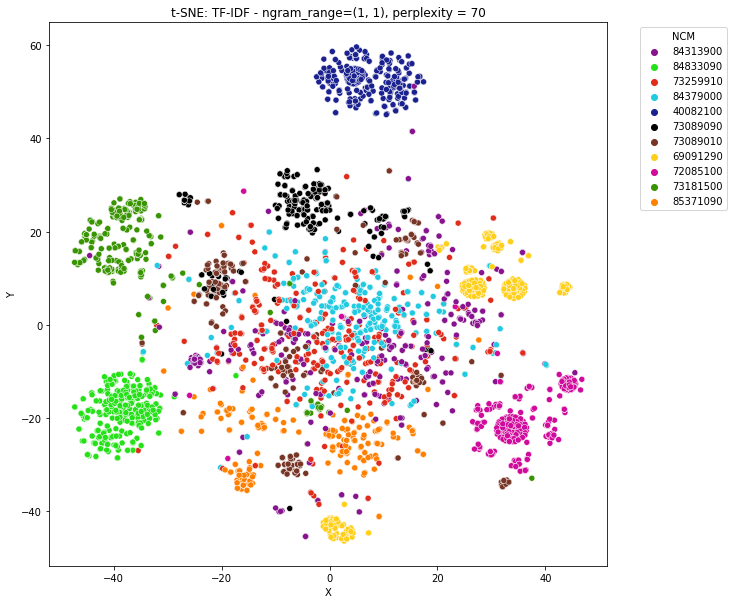

In [26]:
# calcular t-SNE para o dataframe TF-IDF (ngram_range=(1, 1)), perplexity = 70
TSNE_tfidf_v1 = TSNE(n_components=2,
                      random_state=28,
                      perplexity=70,
                      early_exaggeration=12,
                      learning_rate='auto',
                      n_iter=1000,
                      init='pca').fit_transform(df_tfidf_v1.iloc[:, 3:])

df_TSNE = pd.DataFrame(TSNE_tfidf_v1, columns=['X', 'Y'])
df_TSNE_tfidf_v1 = pd.concat([df_tfidf_v1.iloc[:, :3], df_TSNE], axis=1)

#Plot t-SNE
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_TSNE_tfidf_v1, x='X', y='Y', hue='NCM', palette=my_colors)
plt.title("t-SNE: TF-IDF - ngram_range=(1, 1), perplexity = 70")
plt.legend(title='NCM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

##### Termo = palavra por palavra mais palavras dois a dois

In [27]:
# criar um tfidfvectorizer objeto com ngram_range=(1, 2)
vectorizer_TFIDF_v2 = TfidfVectorizer(ngram_range=(1,2))

# criar uma matriz TF-IDF
tfidf_matrix = vectorizer_TFIDF_v2.fit_transform(df_train['DESC'])

# converter a matriz TF-IDF em um dataframe
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer_TFIDF_v2.get_feature_names_out())

# combinar o dataframe original com o dataframe bag-of-words
df_tfidf_v2 = pd.concat([df_train, tfidf_df], axis=1)

# visualizar dados
df_tfidf_v2.head()

,ID,DESC,NCM,00,00 00,00 cp,00 mb1,00 pe,00 sp1,000,...,zinc marc,zinc pacot,zinc pin,zincada,zincada fur,zincada plaquet,zon,zon 21,zxl,zxl laranj
0,T0059023,transica superi el-06-07 conf de 70901564,84313900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TP0019859,caix metal p/rol marc fcm ref sbma-22-bc-tfr 2...,84833090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,T0030762,registr pneuma 550 x 550 - cilindr ext,73259910,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,T0040384,cj apoi 03 estrut,84379000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,T0101129,"lencol de borrach nbr 3/16plg - 4,8x51x1230mm ...",40082100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


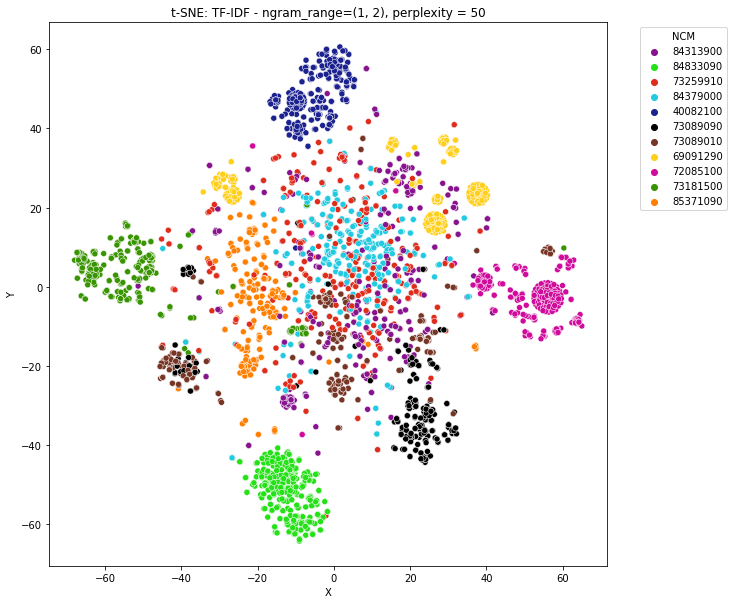

In [28]:
# calcular t-SNE para o dataframe TF-IDF (ngram_range=(1, 2)), perplexity = 50
TSNE_tfidf_v2 = TSNE(n_components=2,
                      random_state=28,
                      perplexity=50,
                      early_exaggeration=12,
                      learning_rate='auto',
                      n_iter=1000,
                      init='pca').fit_transform(df_tfidf_v2.iloc[:, 3:])

df_TSNE = pd.DataFrame(TSNE_tfidf_v2, columns=['X', 'Y'])
df_TSNE_tfidf_v2 = pd.concat([df_tfidf_v2.iloc[:, :3], df_TSNE], axis=1)

# plot t-SNE
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_TSNE_tfidf_v2, x='X', y='Y', hue='NCM', palette=my_colors)
plt.title("t-SNE: TF-IDF - ngram_range=(1, 2), perplexity = 50")
plt.legend(title='NCM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


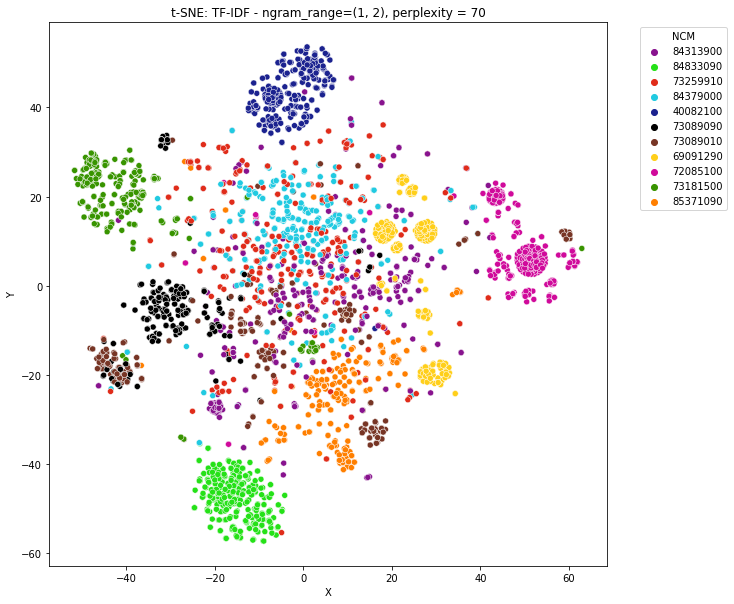

In [29]:
# calcular t-SNE para o dataframe TF-IDF (ngram_range=(1, 2)), perplexity = 70
TSNE_tfidf_v2 = TSNE(n_components=2,
                      random_state=28,
                      perplexity=70,
                      early_exaggeration=12,
                      learning_rate='auto',
                      n_iter=1000,
                      init='pca').fit_transform(df_tfidf_v2.iloc[:, 3:])

df_TSNE = pd.DataFrame(TSNE_tfidf_v2, columns=['X', 'Y'])
df_TSNE_tfidf_v2 = pd.concat([df_tfidf_v2.iloc[:, :3], df_TSNE], axis=1)

# plot t-SNE
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_TSNE_tfidf_v2, x='X', y='Y', hue='NCM', palette=my_colors)
plt.title("t-SNE: TF-IDF - ngram_range=(1, 2), perplexity = 70")
plt.legend(title='NCM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Diffusion Map
##### Aplicação do método Diffusion Map para redução de dimensionalidade na base de dados escolhida (TF-IDF com termos igual a palavra por palavra mais palavras dois a dois).

In [30]:
# parametros do metodo diffusion map
random.seed(28)
n_comp = 50
mydmap = dm.DiffusionMap.from_sklearn(#parametros
                                      n_evecs = n_comp,
                                      alpha=0.5,
                                      oos='nystroem',
                                      #kernel
                                      k=70,
                                      kernel_type="gaussian",
                                      epsilon="bgh",
                                      metric="euclidean")

# aplicar metodo diffusion map
dmap = mydmap.fit_transform(df_tfidf_v2.iloc[:, 3:])

In [31]:
# transformar output em dataframe
dmap_df = pd.DataFrame(dmap)
dmap_df.columns = ['Componente {}'.format(i+1) for i in range(n_comp)]

# unir dataframes
df_train = pd.concat([df_tfidf_v2.iloc[:, :3], dmap_df], axis=1)

# visualizar dados
df_train.head()

,ID,DESC,NCM,Componente 1,Componente 2,Componente 3,Componente 4,Componente 5,Componente 6,Componente 7,...,Componente 41,Componente 42,Componente 43,Componente 44,Componente 45,Componente 46,Componente 47,Componente 48,Componente 49,Componente 50
0,T0059023,transica superi el-06-07 conf de 70901564,84313900,0.013818,0.024004,0.032577,0.008721,0.003659,-0.004530,0.030130,...,0.006359,0.004400,0.002981,0.023897,0.005781,-0.004924,0.010451,0.012042,-0.033700,-0.008394
1,TP0019859,caix metal p/rol marc fcm ref sbma-22-bc-tfr 2...,84833090,-0.326876,-0.079485,-0.021318,-0.002749,-0.006680,0.000254,-0.012984,...,-0.000664,-0.000275,0.000315,-0.000539,0.000515,-0.000619,-0.000586,0.000023,-0.001539,0.000509
2,T0030762,registr pneuma 550 x 550 - cilindr ext,73259910,0.022449,0.032361,0.016260,-0.049208,0.008567,0.020877,0.007087,...,-0.008663,-0.004160,-0.009920,-0.018250,0.033302,-0.035604,0.068281,-0.048088,-0.127302,0.060636
3,T0040384,cj apoi 03 estrut,84379000,0.014818,0.022352,0.028957,0.005609,0.000648,-0.005152,0.032812,...,0.015007,-0.005731,0.010925,-0.003064,0.004096,-0.006445,-0.004193,0.001321,0.011421,-0.012672
4,T0101129,"lencol de borrach nbr 3/16plg - 4,8x51x1230mm ...",40082100,0.031857,0.047089,0.050194,-0.199579,0.029488,0.067508,-0.049901,...,-0.000212,-0.000614,-0.002495,0.001926,0.000747,0.000066,0.000070,0.002359,-0.001289,-0.001713


#### Grid-Search

##### Aplicação do método GridSearchCV para escolha dos melhores hiperparâmetros.

In [32]:
 # separar banco de dados de treino em X e y
 X_train = df_train.iloc[:, 3:]
 y_train = df_train["NCM"]

In [33]:
# primeiro gridsearchcv (todos os kernels, exceto polinomial)
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['linear','rbf','sigmoid'],
              'decision_function_shape': ['ovo', 'ovr']}

# aplicar gridsearchcv aos dados
grid = GridSearchCV(SVC(),param_grid, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['linear', 'rbf', 'sigmoid']})

In [34]:
# exibir resultados
print(grid.best_params_)

{'C': 100, 'decision_function_shape': 'ovo', 'gamma': 10, 'kernel': 'rbf'}


In [35]:
# segundo gridsearchcv (kernel polinomial)
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000],
              'gamma': [ 10, 1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['poly'],
              'decision_function_shape': ['ovo','ovr'],
              'degree': [3, 4, 5, 6]}

# aplicar gridsearchcv aos dados
grid = GridSearchCV(SVC(),param_grid, cv=3)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'decision_function_shape': ['ovo', 'ovr'],
                         'degree': [3, 4, 5, 6],
                         'gamma': [10, 1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['poly']})

In [36]:
# exibir resultados
print(grid.best_params_)

{'C': 1000, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 10, 'kernel': 'poly'}


#### Support Vector Machine
##### Aplicação do algoritmo SVM aos dados usando os parâmetros escolhidos pelo método Grid-Search e verificação das métricas do modelo.

In [37]:
# transfomar dados de teste
df_test_cabecalho = df_test.iloc[:, [0,2]]
df_test_desc = df_test.iloc[:, 1:2]

# tranformar em uma matriz TF-IDF
tfidf_matrix = vectorizer_TFIDF_v2.transform(df_test_desc['DESC'])

# converter a matriz em um dataframe
df_test_desc = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer_TFIDF_v2.get_feature_names_out())

# montar dataframe para visualizacao do BOW de teste
df_bow_test = pd.concat([df_test_cabecalho, df_test_desc], axis=1)
df_bow_test.head()

,ID,NCM,00,00 00,00 cp,00 mb1,00 pe,00 sp1,000,000 mm,...,zinc marc,zinc pacot,zinc pin,zincada,zincada fur,zincada plaquet,zon,zon 21,zxl,zxl laranj
0,T0111122,84833090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,T0020767,73089090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,T0107387,84313900,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TP0017813,73181500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,T0055260,85371090,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


c:\Users\franc\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


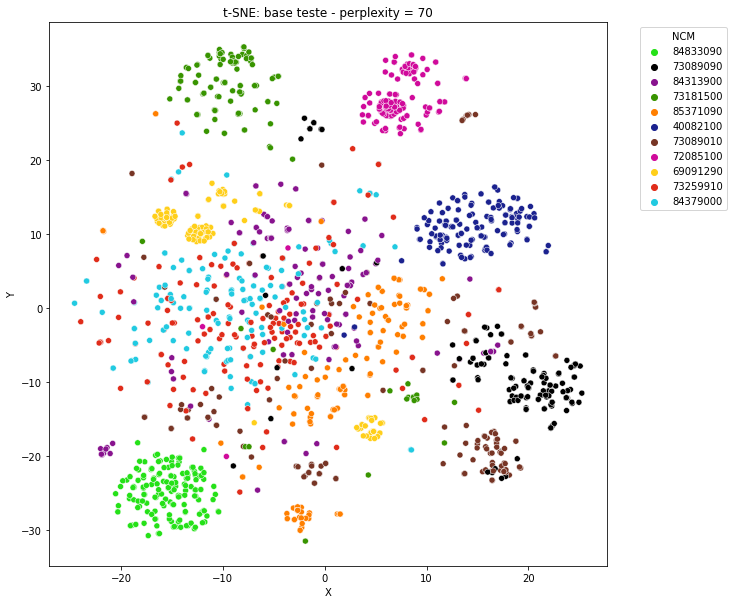

In [38]:
# calcular t-SNE para o dataframe teste, perplexity = 70
TSNE_teste = TSNE(n_components=2,
                  random_state=28,
                  perplexity=70,
                  early_exaggeration=12,
                  learning_rate='auto',
                  n_iter=1000,
                  init='pca').fit_transform(df_bow_test.iloc[:, 3:])

df_TSNE = pd.DataFrame(TSNE_teste, columns=['X', 'Y'])
df_TSNE_teste = pd.concat([df_bow_test.iloc[:, :3], df_TSNE], axis=1)

# plot t-SNE
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(data=df_TSNE_teste, x='X', y='Y', hue='NCM', palette=my_colors)
plt.title("t-SNE: base teste - perplexity = 70")
plt.legend(title='NCM', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [39]:
# transformar variaveis via diffusion map
random.seed(28)
df_test_desc = pd.DataFrame(mydmap.transform(df_test_desc))
df_test_desc.columns = ['Componente {}'.format(i+1) for i in range(n_comp)]

# unir dataframes
df_test = pd.concat([df_test_cabecalho, df_test_desc], axis=1)

# visualizar dados
df_test.head()

,ID,NCM,Componente 1,Componente 2,Componente 3,Componente 4,Componente 5,Componente 6,Componente 7,Componente 8,...,Componente 41,Componente 42,Componente 43,Componente 44,Componente 45,Componente 46,Componente 47,Componente 48,Componente 49,Componente 50
0,T0111122,84833090,-0.326533,-0.079222,-0.021358,-0.002690,-0.006599,0.000208,-0.012898,-0.013777,...,-0.000668,-0.000467,0.000380,-0.000780,0.000552,-0.000980,-0.000668,0.000284,-0.001412,0.000094
1,T0020767,73089090,0.024873,0.039242,0.054331,0.012909,-0.014814,-0.147583,-0.044555,-0.013877,...,0.002140,0.003801,0.002178,0.001914,-0.005602,-0.004304,0.020407,0.026991,-0.049147,-0.017160
2,T0107387,84313900,0.015556,0.032589,0.059080,0.096370,0.137498,0.049351,-0.033173,-0.003588,...,0.000851,0.000110,0.001004,0.010614,0.006873,-0.003597,0.001270,-0.000609,0.000825,0.006413
3,TP0017813,73181500,0.017609,0.036663,0.022090,0.005575,-0.003985,-0.057874,0.006324,0.048743,...,0.001364,-0.002719,-0.002675,-0.002153,0.005346,0.003567,0.003353,0.008283,0.011592,-0.007539
4,T0055260,85371090,0.001345,0.035529,-0.020065,0.010573,0.010277,-0.002051,0.018663,0.031309,...,-0.000288,0.002801,-0.002151,-0.001711,-0.001670,0.004590,0.005977,0.001926,-0.009802,0.004335


In [40]:
# criar SVM - usando o resultado do primeiro gridsearchcv
clf1 = SVC(C = 100,
           kernel='rbf',
           gamma = 10,
           decision_function_shape='ovo')

# ajustar modelo
clf1.fit(X_train, y_train)

# prever respostas para o dataset de teste
pred1 = clf1.predict(df_test.iloc[:,2:])

In [41]:
# exibir metricas do modelo
print(metrics.classification_report(df_test["NCM"], pred1, digits=4))

              precision    recall  f1-score   support

    40082100     0.9819    0.9939    0.9879       164
    69091290     0.9571    1.0000    0.9781       134
    72085100     0.9926    0.9783    0.9854       138
    73089010     0.8631    0.8529    0.8580       170
    73089090     0.9000    0.8834    0.8916       163
    73181500     0.9589    0.9790    0.9689       143
    73259910     0.5704    0.5260    0.5473       154
    84313900     0.6532    0.6136    0.6328       132
    84379000     0.6538    0.7445    0.6962       137
    84833090     1.0000    1.0000    1.0000       156
    85371090     1.0000    0.9811    0.9905       159

    accuracy                         0.8709      1650
   macro avg     0.8665    0.8684    0.8670      1650
weighted avg     0.8700    0.8709    0.8700      1650



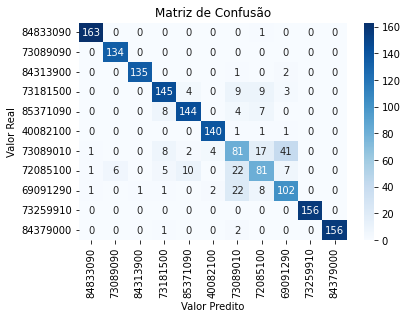

In [42]:
# matriz de confusão - plot
sns.heatmap(metrics.confusion_matrix(df_test["NCM"], pred1), annot=True, cmap="Blues", fmt="d", xticklabels=df_test["NCM"].unique(), yticklabels=df_test["NCM"].unique())
plt.ylabel("Valor Real")
plt.xlabel("Valor Predito")
plt.title("Matriz de Confusão")
plt.show()

In [43]:
# criar SVM - usando o resultado do segundo gridsearchCV
clf2 = SVC(C = 1000,
           kernel ='poly',
           gamma = 10,
           decision_function_shape ='ovo',
           degree = 3)

# ajustar o modelo
clf2.fit(X_train, y_train)

# prever respostas para o dataset de teste
pred2 = clf2.predict(df_test.iloc[:,2:])

In [44]:
# exibir metricas do modelo
print(metrics.classification_report(df_test["NCM"], pred2, digits=4))

              precision    recall  f1-score   support

    40082100     0.9819    0.9939    0.9879       164
    69091290     1.0000    0.9925    0.9963       134
    72085100     1.0000    0.9710    0.9853       138
    73089010     0.8875    0.8353    0.8606       170
    73089090     0.9103    0.8712    0.8903       163
    73181500     0.9722    0.9790    0.9756       143
    73259910     0.5671    0.6039    0.5849       154
    84313900     0.7131    0.6591    0.6850       132
    84379000     0.6287    0.7664    0.6908       137
    84833090     1.0000    1.0000    1.0000       156
    85371090     1.0000    0.9308    0.9642       159

    accuracy                         0.8745      1650
   macro avg     0.8783    0.8730    0.8746      1650
weighted avg     0.8812    0.8745    0.8769      1650



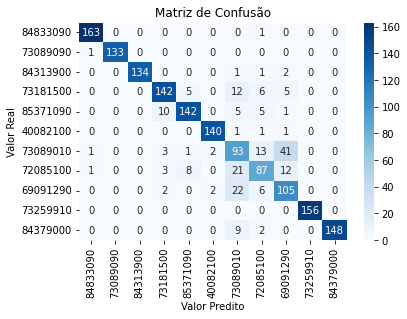

In [45]:
# matriz de confusao - plot
sns.heatmap(metrics.confusion_matrix(df_test["NCM"], pred2), annot=True, cmap="Blues", fmt="d", xticklabels=df_test["NCM"].unique(), yticklabels=df_test["NCM"].unique())
plt.ylabel("Valor Real")
plt.xlabel("Valor Predito")
plt.title("Matriz de Confusão")
plt.show()